### Описание

Интернет-магазин N запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75. 

### Описание данных

Столбец *text* датасета содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer

import lightgbm as lgbm
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

RAND_STATE = 28112020
import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Я\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Я\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Я\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
try:
    df = pd.read_csv(r'datasets/toxic_comments.csv')
except:
    try:
        df = pd.read_csv('/datasets/toxic_comments.csv')
    except:
        print('Ошибка подгрузки данных')

Ознакомимся с данными.

In [4]:
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


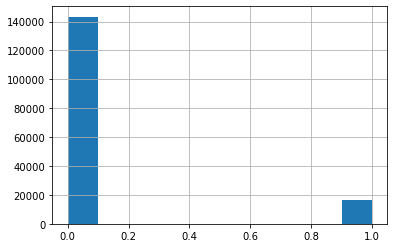

In [5]:
df['toxic'].hist();

In [6]:
df['toxic'].sum() / len(df)

0.10167887648758234

Наблюдаем дисбаланс классов

Избавимся от знаков препинания в текстах, оставим только текст.

In [7]:
def clear_text(text):    
    return " ".join(re.sub(r'[^A-Za-z]', ' ', text).split())

In [8]:
df['cleared_text'] = df['text'].apply(clear_text)
df

,text,toxic,cleared_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,And for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That is a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm theres no actual article for prost...
159569,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...


Лемматизируем текст с помощью `WordNetLemmatizer`

In [9]:
wnl = WordNetLemmatizer()

In [10]:
def lem(text):
    word_list = nltk.word_tokenize(text)    
    lemmatized_output = ' '.join([wnl.lemmatize(word) for word in word_list])    
    return lemmatized_output

In [11]:
%%time
df['lemm_text'] = df['cleared_text'].apply(lem)

Wall time: 2min 18s


In [12]:
df

,text,toxic,cleared_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,You sir are my hero Any chance you remember wh...
...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,And for the second time of asking when your vi...,And for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That is a ho...,You should be ashamed of yourself That is a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm theres no actual article for prost...,Spitzer Umm there no actual article for prosti...
159569,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...,And it look like it wa actually you who put on...


In [13]:
train, test = train_test_split(df, test_size=0.2)

In [14]:
train

,text,toxic,cleared_text,lemm_text
156178,lol...\nwhy dont you stop reverting my edits o...,0,lol why dont you stop reverting my edits on Ti...,lol why dont you stop reverting my edits on Ti...
1383,"Can you, or anyone, please tell me what's goin...",0,Can you or anyone please tell me what s going ...,Can you or anyone please tell me what s going ...
106747,I assume your response means you are not an ad...,0,I assume your response means you are not an ad...,I assume your response mean you are not an adm...
75544,the hebrew should be deleted. ILLEGAL OCCUPATI...,0,the hebrew should be deleted ILLEGAL OCCUPATIO...,the hebrew should be deleted ILLEGAL OCCUPATIO...
141207,"""\n-\n Edit request on 3 August 2012 \n\n98.15...",0,Edit request on August Hello there wiki I have...,Edit request on August Hello there wiki I have...
...,...,...,...,...
17059,Your speculations are unhelpful. The Cherokee ...,0,Your speculations are unhelpful The Cherokee k...,Your speculation are unhelpful The Cherokee ke...
124971,Xavi Pons \n\nWhy is included in the team Stob...,0,Xavi Pons Why is included in the team Stobard ...,Xavi Pons Why is included in the team Stobard ...
123991,""" ...",0,OOAD UML COMPLEX SYSTEMS Attributess of a comp...,OOAD UML COMPLEX SYSTEMS Attributess of a comp...
148928,"Frank Lloyd wright \n\nhi all, first of let me...",0,Frank Lloyd wright hi all first of let me stat...,Frank Lloyd wright hi all first of let me stat...


In [15]:
test

,text,toxic,cleared_text,lemm_text
56088,I am assuming that there is no point trying to...,0,I am assuming that there is no point trying to...,I am assuming that there is no point trying to...
158342,"""\nIn fact, this link is irrelevant to the ari...",0,In fact this link is irrelevant to the aricle ...,In fact this link is irrelevant to the aricle ...
73859,"""\nNo, my edits were entirely reasonable withi...",0,No my edits were entirely reasonable within th...,No my edits were entirely reasonable within th...
87642,"""\n I need to quote you on this part. You sai...",0,I need to quote you on this part You said edit...,I need to quote you on this part You said edit...
96682,"""\n\n re: Deora \n\nHi Pak21, thanks for addin...",0,re Deora Hi Pak thanks for adding context to D...,re Deora Hi Pak thanks for adding context to D...
...,...,...,...,...
38152,I dont believe any of my behavior was inapprop...,0,I dont believe any of my behavior was inapprop...,I dont believe any of my behavior wa inappropr...
30142,"I have posted this source , the report is in h...",0,I have posted this source the report is in htt...,I have posted this source the report is in htt...
2843,touch my wife will not work thru webcam.,0,touch my wife will not work thru webcam,touch my wife will not work thru webcam
27743,Encryption capability \n\nI recommend adding a...,0,Encryption capability I recommend adding a col...,Encryption capability I recommend adding a col...


In [16]:
corpus_train = train['lemm_text'].values.astype('U')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords) # stopwords - список стоп-слов

In [17]:
%%time
tf_idf = count_tf_idf.fit_transform(corpus_train)
tf_idf.shape

Wall time: 12 s


(127656, 144651)

In [18]:
X_train = tf_idf

In [19]:
y_train = train['toxic']

In [20]:
corpus_test = test['lemm_text']
X_test = count_tf_idf.transform(corpus_test)

In [21]:
y_test = test['toxic']

Подгрузили данные, нашли дисбаланс классов. Разбили датасет на трейн и тест, с помощью TF-IDF векторизировали наш корпус слов на трейне, потом обучили его на тесте, получили матрицы для дальнейшей работы.

# 2. Обучение

Будем использовать логистическую регрессию, SVM, LightGBM.

### Logistic Regression

In [22]:
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 10),
    'solver' : ['liblinear'],
}

In [23]:
clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='f1')

In [24]:
%%time
best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 29.0min finished


Wall time: 29min


In [25]:
best_clf.best_estimator_

LogisticRegression(C=2.782559402207126, penalty='l1', solver='liblinear')

In [26]:
best_clf.best_score_

0.7758266206041693

In [27]:
best_clf.best_params_

{'C': 2.782559402207126, 'penalty': 'l1', 'solver': 'liblinear'}

Получили f1-метрику на валидации 0,77 с помощью логистической регрессии через сетку.

Обучим модель на этих параметрах.

In [28]:
model = LogisticRegression(**best_clf.best_params_)

In [29]:
%%time
model.fit(X_train, y_train)

Wall time: 1.75 s


LogisticRegression(C=2.782559402207126, penalty='l1', solver='liblinear')

In [30]:
pred_train = model.predict(X_train)

In [31]:
f1_score(pred_train, y_train)

0.846399730820996

In [32]:
pred_test = model.predict(X_test)

In [33]:
f1_score(pred_test, y_test)

0.7827545713806409

Получили f1-метрику 0,78 на логистической регрессии.

### SVM

In [34]:
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 9),
    'class_weight': ['balanced', None],
    'loss': ['hinge', 'squared_hinge']
}

In [35]:
clf = GridSearchCV(LinearSVC(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='f1')

In [36]:
%%time
best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.5min finished


Wall time: 3min 31s


In [37]:
best_clf.best_estimator_

LinearSVC()

In [38]:
best_clf.best_score_

0.7701895437676258

In [39]:
best_clf.best_params_

{'C': 1.0, 'class_weight': None, 'loss': 'squared_hinge', 'penalty': 'l2'}

Получили f1-метрику на валидации 0,77 с помощью SVM через сетку.

Обучим модель на этих параметрах.

In [40]:
svc = LinearSVC(**best_clf.best_params_)

In [41]:
%%time
svc.fit(X_train, y_train)

Wall time: 940 ms


LinearSVC()

In [42]:
svc_pred_train = svc.predict(X_train)

In [43]:
f1_score(svc_pred_train, y_train)

0.9279606324620845

In [44]:
svc_pred_test = svc.predict(X_test)

In [45]:
f1_score(svc_pred_test, y_test)

0.7793443179887889

SVM показал такую же метрику, как и логистическая регрессия, f1 в районе 0,78.

### LightGBM

In [46]:
param_grid = {
    'application': ['f1'],
    'objective': ['binary'],
    'metric': ['f1'],
    'class_weight': ['balanced', None],
    'num_leaves': [10, 30, 100],
    'max_depth': [10, 30, 100],
    'subsample_for_bin': [10000]
}

In [47]:
clf = GridSearchCV(LGBMClassifier(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='f1')

In [48]:
%%time
best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  9.6min finished


Wall time: 9min 58s


In [49]:
best_clf.best_estimator_

LGBMClassifier(application='f1', max_depth=100, metric='f1', num_leaves=100,
               objective='binary', subsample_for_bin=10000)

In [50]:
best_clf.best_score_

0.764232772508554

In [51]:
best_clf.best_params_

{'application': 'f1',
 'class_weight': None,
 'max_depth': 100,
 'metric': 'f1',
 'num_leaves': 100,
 'objective': 'binary',
 'subsample_for_bin': 10000}

Получили f1-метрику на валидации 0,76 с помощью LightGBM через сетку.

Обучим модель на этих параметрах.

In [52]:
lgbm_model = LGBMClassifier(**best_clf.best_params_)

In [53]:
%%time
lgbm_model.fit(X_train, y_train)

Wall time: 18.8 s


LGBMClassifier(application='f1', max_depth=100, metric='f1', num_leaves=100,
               objective='binary', subsample_for_bin=10000)

In [54]:
lgbm_pred_train = lgbm_model.predict(X_train)

In [55]:
f1_score(lgbm_pred_train, y_train)

0.8542905692438404

In [56]:
lgbm_pred_test = lgbm_model.predict(X_test)

In [58]:
f1_score(lgbm_pred_test, y_test)

0.769546621043627

LightGBM показал меньшее значение метрики f1, в районе 0,77.

# 3. Выводы

Нашей задачей было создать инструмент, позволяющий фильтровать токсичные комментарии и отправлять их на модерацию. Требуемая метрика f1 была 0,75. Логистическая регрессия показала себя лучше всего, f1=0.78, LightGBM показал худший результат, в районе 0,77.